In [1]:
import h5py
import copy
import lmfit
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from rich.progress import Progress
from scipy.stats import binned_statistic
from utils.plot_utils import set_fontsize
from utils.hdf_utils import load_measurement_data_devices_attrs

In [91]:
def ratio_with_error(a,b,σa,σb):
    ratio = a/b
    err = ratio * np.sqrt((σa/a)**2 + (σb/b)**2)
    return ratio, err

In [2]:
hdf_dir = Path("../data")

In [3]:
yag_channel = 0
pmt_channel = 1
pd_channel = 2
pdn_channel = 3
shutter_channel = 4
pdrc_channel = 5

In [22]:
fname = "2021_3_9.hdf"

with h5py.File(hdf_dir / fname, 'r') as f:
    dset_names = list(f.keys())
    for idn, name in enumerate(f.keys()):
        print(f"{idn:<2} <> {name:<60} : {len(f[name]['readout']['PXIe-5171'])}")

0  <> 1615310812 find R0 F1                                        : 1081
1  <> 1615314178 find P2 F1                                        : 51
2  <> 1615319897 find P2 F1                                        : 136
3  <> 1615320080 find P2 F1                                        : 526
4  <> 1615320469 find P2 F1                                        : 576
5  <> 1615321008 find Q1                                           : 751
6  <> 1615322092 find Q1                                           : 391
7  <> 1615322309 find J1J2                                         : 3751
8  <> 1615324699 find R0 F1                                        : 966
9  <> 1615325749 scan P2 F1 with microwes on det R0 F1             : 1
10 <> 1615326244 scan P2 F1 with microwes on det R0 F1             : 601
11 <> 1615327440 scan P2 F1 with microwes on det R0 F1             : 6051
12 <> 1615332741 scan P2 F1 with microwes on det R0 F1             : 881
13 <> 1615333784 scan P2 F1 with microwes on det R0

In [25]:
slice_flm  = np.s_[100:250]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

# Microwave Scan J1 $\rightarrow$ J2 with P2 F1 on, detection on Q1

In [130]:
dset_name = dset_names[7]
devices = ()

In [131]:
scan_parameter = 'SynthHD Pro SetFrequencyCHAGUI'

In [132]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

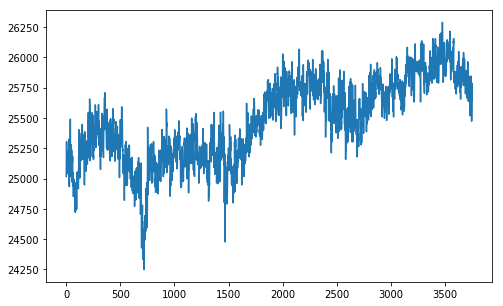

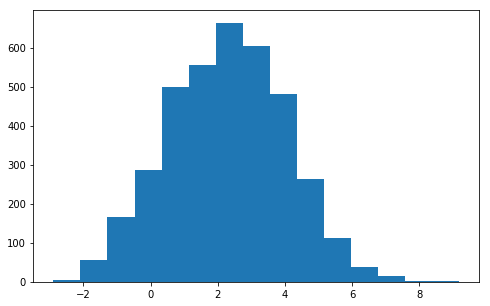

In [133]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pdn_data.mean(axis = 1))

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), 
        bins = 15);

In [134]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < 250
mask_pdn = pdn_data.min(axis = 1) < 19000
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < .5

mask = mask_yag | mask_pdn | mask_abs

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]


absorption_integral = np.trapz(norm_data_norm[:, slice_absi])
fluorescence_integral = np.trapz(pmt_data_norm[:, slice_fli])

In [135]:
bin_width = np.diff(np.unique(scan_parameters))[0]
bins = np.arange(np.unique(scan_parameters).min()-bin_width/2, np.unique(scan_parameters).max()+bin_width, bin_width)
stat, bin_edges, bin_number = binned_statistic(scan_parameters, fluorescence_integral/absorption_integral, 
                                               lambda x: np.nanmean(x), bins = bins) 
err, bin_edges, bin_number = binned_statistic(scan_parameters, fluorescence_integral/absorption_integral, 
                                              lambda x: np.nanstd(x)/(np.sqrt(len(x))-1), bins = bins) 

bin_means = bin_edges[:-1]+bin_width/2

Depletion of 6.4 %


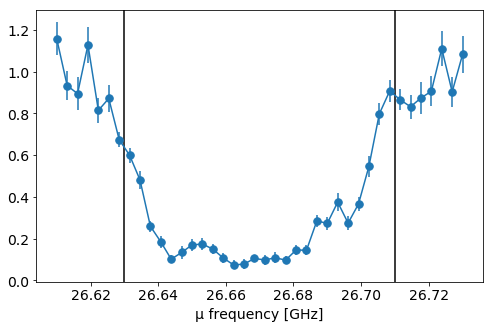

In [145]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means*2/1e9, stat/stat[-4:].mean(), yerr = err/stat[-4:].mean(), fmt = '.', ms = 15, linestyle = '-')

ax.set_xlabel('μ frequency [GHz]')

ax.axvline(26.63, color = 'k', zorder = 1)
ax.axvline(26.71, color = 'k', zorder = 1)

set_fontsize(ax, 14)

print(f"Depletion of {stat.min()/stat.max()* 100:.1f} %")

# Scan P2 F1 with microwaves on J1 $\rightarrow$ J2 with R0 F1 detection
~30 mW

In [81]:
dset_name = dset_names[11]
devices = ()

In [82]:
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

In [83]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

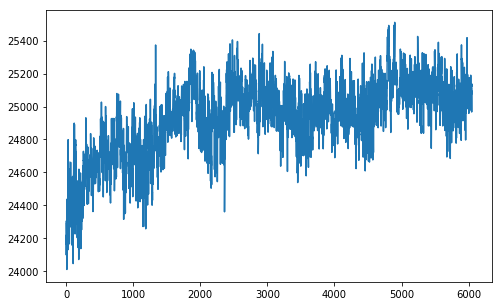

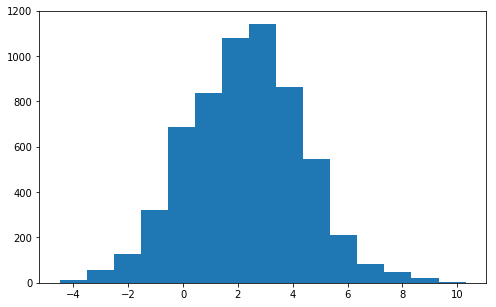

In [84]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pdn_data.mean(axis = 1))

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), 
        bins = 15);

In [97]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < 250
mask_pdn = pdn_data.min(axis = 1) < 19000
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < 1
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < -5000

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

In [98]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

bin_width = np.diff(np.unique(scan_parameters)).min()
bins = np.arange(np.unique(scan_parameters).min()-bin_width/2, np.unique(scan_parameters).max()+bin_width/2, bin_width)

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat, bin_edges, bin_number = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanmean(x), bins = bins)
    err, _, _ = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanstd(x)/np.sqrt(len(x)-1), bins = bins)
    results.append((stat, err, bin_number))
    
bin_means = bin_edges[:-1]+bin_width/2

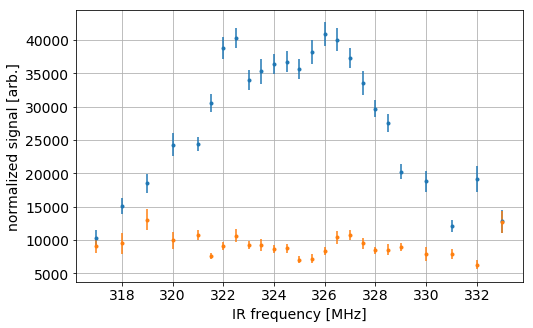

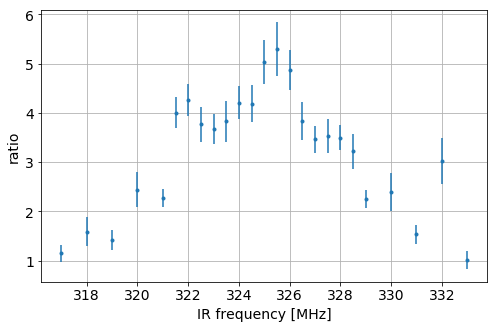

In [101]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)

set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

# Scan P2 F1 with microwaves on J1 $\rightarrow$ J2 with R0 F1 detection
~40 mW

In [102]:
dset_name = dset_names[20]
devices = ()

In [103]:
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

In [105]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
# pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

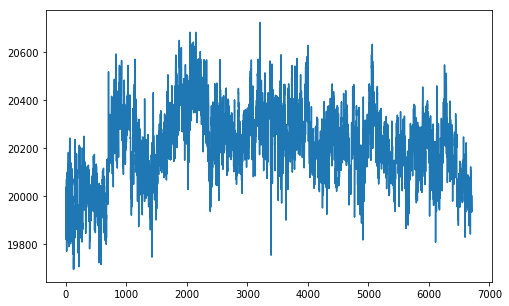

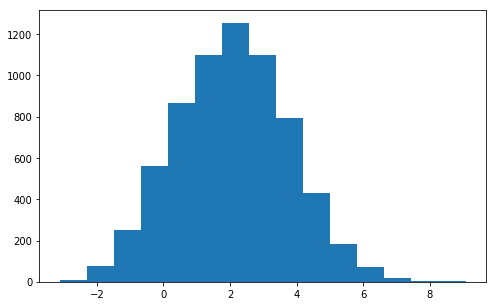

In [106]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pdn_data.mean(axis = 1))

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), 
        bins = 15);

In [107]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < 250
mask_pdn = pdn_data.min(axis = 1) < 19000
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < 1
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < -5000

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

In [108]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

bin_width = np.diff(np.unique(scan_parameters)).min()
bins = np.arange(np.unique(scan_parameters).min()-bin_width/2, np.unique(scan_parameters).max()+bin_width/2, bin_width)

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat, bin_edges, bin_number = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanmean(x), bins = bins)
    err, _, _ = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanstd(x)/np.sqrt(len(x)-1), bins = bins)
    results.append((stat, err, bin_number))
    
bin_means = bin_edges[:-1]+bin_width/2

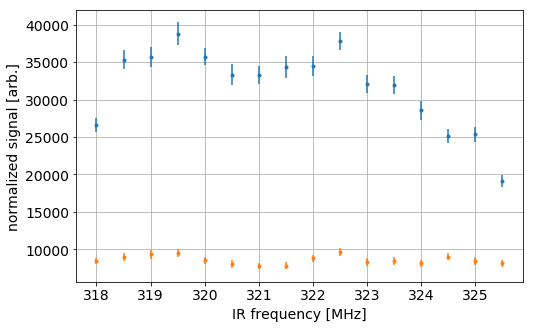

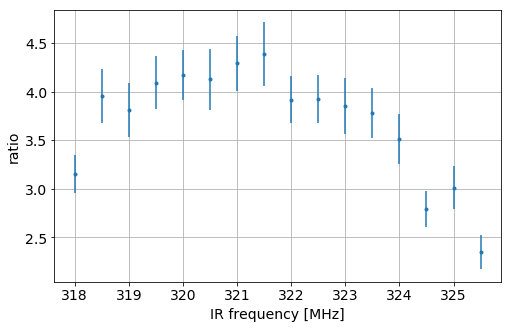

In [109]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)

set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

# Scan P2 F1 without microwaves with R0 F1 detection
~40 mW

In [110]:
dset_name = dset_names[21]
devices = ()

In [111]:
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

In [112]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
# pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

C:\Users\CeNTREX\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


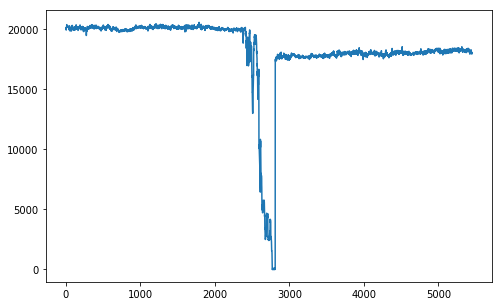

In [125]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pdn_data.mean(axis = 1))

# fig, ax = plt.subplots(figsize = (8,5))
# ax.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), 
#         bins = 15);

In [126]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < 250
mask_pdn = pdn_data.min(axis = 1) < 16000
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < 1
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < -5000

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

C:\Users\CeNTREX\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in subtract
  


In [127]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

bin_width = np.diff(np.unique(scan_parameters)).min()
bins = np.arange(np.unique(scan_parameters).min()-bin_width/2, np.unique(scan_parameters).max()+bin_width/2, bin_width)

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat, bin_edges, bin_number = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanmean(x), bins = bins)
    err, _, _ = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanstd(x)/np.sqrt(len(x)-1), bins = bins)
    results.append((stat, err, bin_number))
    
bin_means = bin_edges[:-1]+bin_width/2

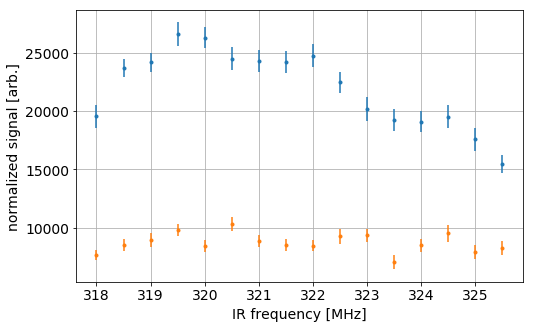

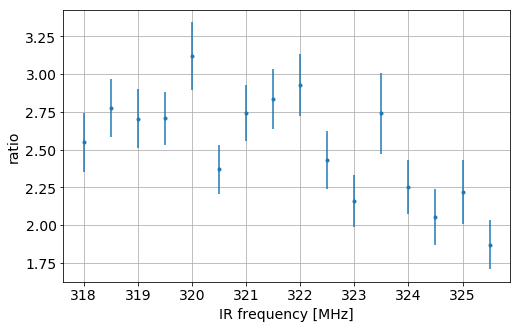

In [128]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)

set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)